# Week 4 — Logistic Regression + Feature Scaling (CKD Only)

**Author**: James N. Hardison II  
**Date**: 2025-09-25  
**Course**: DX799 O1 — Mod C (Semester 1)

**Goal**: Use logistic regression on the CKD dataset with basic feature scaling. Keep it simple and clear.

## 1. Project Context (Short)
- Dataset: `ckd_dataset_v2.csv`
- Task: Binary classification for a CKD-related outcome (0/1).  
- Why it matters: Identify signals tied to disease presence or progression for early action.


## 2. Setup and Data Loading

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load CKD dataset (only this one)
CKD_PATH = "ckd_dataset_v2.csv"
df = pd.read_csv(CKD_PATH)

# Clean column names a bit
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print(df.shape)
df.head()

(202, 29)


,bp_(diastolic),bp_limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


## 3. Quick EDA (Keep It Short)

In [52]:
# Basic info
display(df.head())
print("\nMissing by column (top 10):")
display(df.isna().mean().sort_values(ascending=False).head(10))

,bp_(diastolic),bp_limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12



Missing by column (top 10):


bp_(diastolic)    0.00495
bp_limit          0.00495
sg                0.00495
al                0.00495
class             0.00495
rbc               0.00495
su                0.00495
pc                0.00495
pcc               0.00495
ba                0.00495
dtype: float64

## 4. Target + Features
Set the `target_col` to the binary outcome. The helper tries common names. If it fails, set it manually (e.g., `target_col = "ckd"`).

In [ ]:
# Try common binary target names
candidates = ["target","label","outcome","ckd","has_ckd","y","class","progression"]
target_col = None
for c in candidates:
    if c in df.columns and df[c].nunique(dropna=True) <= 3:
        target_col = c
        break
# target_col = "ckd"

print("Target guess:", target_col)
if target_col is None:
    raise ValueError("Set target_col above to a binary column in the dataset.")

print("Value counts:")
print(df[target_col].value_counts(dropna=False))

Target guess: class
Value counts:
class
ckd         128
notckd       72
NaN           1
discrete      1
Name: count, dtype: int64


## 5. Train/Test Split and Simple Preprocessing

In [ ]:
# 5. Train/Test Split and Simple Preprocessing
# Goal: clean target → split → impute → one-hot → align → scale


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) Clean the target to 0/1
# -----------------------------
y_raw = df[target_col]

# If target is text, map common labels to 0/1
if y_raw.dtype == "O" or str(y_raw.dtype).startswith("category"):
    y_norm = y_raw.astype(str).str.strip().str.lower()
    pos = {"ckd","yes","y","true","1","positive","present","disease","progression"}
    neg = {"notckd","no","n","false","0","negative","absent","control"}
    y_num = y_norm.map(lambda v: 1 if v in pos else 0 if v in neg else np.nan)
else:
    y_num = pd.to_numeric(y_raw, errors="coerce")

# Keep only rows with 0 or 1
mask = y_num.isin([0, 1])
df = df.loc[mask].copy()
df[target_col] = y_num.loc[mask].astype(int)

y = df[target_col].astype(int)
X = df.drop(columns=[target_col]).copy()

print("Target counts after cleaning:\n", y.value_counts())

# -----------------------------
# 2) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# -----------------------------
# 3) Identify column types from TRAIN only
# -----------------------------
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

# Replace inf with NaN in numeric cols before imputing
if num_cols:
    X_train[num_cols] = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
    X_test[num_cols]  = X_test[num_cols].replace([np.inf, -np.inf], np.nan)

# Drop columns that are all NaN in TRAIN (imputers cannot learn on them)
drop_num_all_nan = [c for c in num_cols if X_train[c].isna().all()]
drop_cat_all_nan = [c for c in cat_cols if X_train[c].isna().all()]
if drop_num_all_nan:
    X_train = X_train.drop(columns=drop_num_all_nan)
    X_test  = X_test.drop(columns=drop_num_all_nan, errors="ignore")
    num_cols = [c for c in num_cols if c not in drop_num_all_nan]
if drop_cat_all_nan:
    X_train = X_train.drop(columns=drop_cat_all_nan)
    X_test  = X_test.drop(columns=drop_cat_all_nan, errors="ignore")
    cat_cols = [c for c in cat_cols if c not in drop_cat_all_nan]

# -----------------------------
# 4) Impute using TRAIN stats
# -----------------------------
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

if num_cols:
    X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
    X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

if cat_cols:
    X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
    X_test[cat_cols]  = cat_imputer.transform(X_test[cat_cols])

# -----------------------------
# 5) One-hot encode categoricals and align columns
# -----------------------------
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# Align to the same columns. Fill missing dummies with 0.
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# -----------------------------
# 6) Scale numeric features using TRAIN fit only
# -----------------------------
scaler = StandardScaler()
# scale only original continuous numeric columns (not the one-hot dummies)
num_cols_to_scale = [c for c in num_cols if c in X_train.columns]

if num_cols_to_scale:
    X_train[num_cols_to_scale] = scaler.fit_transform(X_train[num_cols_to_scale].astype(float))
    X_test[num_cols_to_scale]  = scaler.transform(X_test[num_cols_to_scale].astype(float))
else:
    print("No numeric columns to scale.")

# -----------------------------
# 7) Sanity checks
# -----------------------------
print("Shapes:", X_train.shape, X_test.shape)
print("NaNs in X_train:", int(X_train.isna().sum().sum()))
print("NaNs in X_test :", int(X_test.isna().sum().sum()))
print("NaNs in y_train:", int(y_train.isna().sum()))
print("NaNs in y_test :", int(y_test.isna().sum()))


Target counts after cleaning:
 class
1    128
0     72
Name: count, dtype: int64
No numeric columns to scale.
Shapes: (160, 112) (40, 112)
NaNs in X_train: 0
NaNs in X_test : 0
NaNs in y_train: 0
NaNs in y_test : 0


## 6. Baseline Logistic Regression (L2 regularization)

In [55]:
logreg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1: {f1:.3f}")
print(f"ROC AUC: {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
ROC AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        26

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



## 7. Simple Hyperparameter Tuning (C only, keep it small)

In [56]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best C:", grid.best_params_['C'])
print("Best CV AUC:", grid.best_score_)

# Evaluate best model
y_pred_g = best_model.predict(X_test)
y_proba_g = best_model.predict_proba(X_test)[:, 1]

print("\nTest (best model):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_g):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_g, zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_g, zero_division=0):.3f}")
print(f"F1: {f1_score(y_test, y_pred_g, zero_division=0):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_g):.3f}")

Best C: 0.01
Best CV AUC: 1.0

Test (best model):
Accuracy: 0.950
Precision: 0.929
Recall: 1.000
F1: 0.963
ROC AUC: 1.000


## 8. Plots (ROC + Confusion Matrix)

<Figure size 600x500 with 0 Axes>

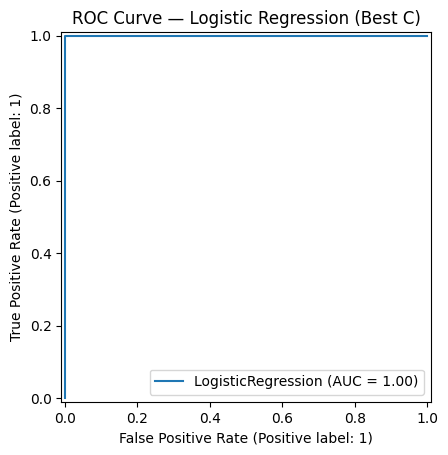

<Figure size 500x500 with 0 Axes>

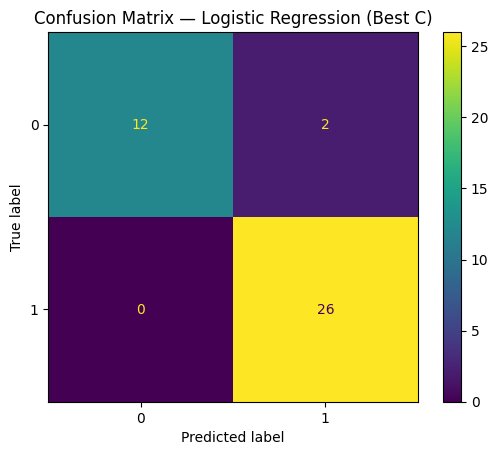

In [57]:
fig = plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve — Logistic Regression (Best C)")
plt.show()

fig = plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix — Logistic Regression (Best C)")
plt.show()

## 9. Interpret Coefficients (Top 15 by magnitude)

In [58]:
coefs = pd.Series(best_model.coef_.ravel(), index=X_train.columns)
coefs_abs = coefs.abs().sort_values(ascending=False)
display(pd.DataFrame({
    'feature': coefs_abs.index[:15],
    'coef': coefs[coefs_abs.index[:15]].values
}))

,feature,coef
0,affected_1,0.254431
1,al_< 0,-0.148240
2,htn_1,0.140625
3,dm_1,0.126935
4,bu_< 48.1,-0.121260
5,grf_< 26.6175,0.109812
6,sg_≥ 1.023,-0.104859
7,pcv_41.3 - 45.2,-0.086556
8,hemo_11.3 - 12.6,0.081136
9,bp_limit_2,0.080297
